In [38]:
import os
import numpy as np
from os.path import isfile, join
import cv2
from PIL import Image
from keras.layers import GlobalAveragePooling2D, Dropout, BatchNormalization, Dense
import tensorflow
from tensorflow.keras.applications.densenet import DenseNet201
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import glob

In [6]:
benign_dir = "Dataset_BUSI_with_GT/benign"
malignant_dir = "Dataset_BUSI_with_GT/malignant"

In [9]:
benign = []
malignant = []

benign_image_paths = glob.glob(os.path.join(benign_dir, "*.png"))
malignant_image_paths = glob.glob(os.path.join(malignant_dir, "*.png"))

for image_path in benign_image_paths:
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    benign.append(img)
    
for image_path in malignant_image_paths:
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    malignant.append(img)

In [13]:
benign_label = np.zeros(len(benign))
malignant_label = np.zeros(len(malignant))

X = np.concatenate((benign, malignant), axis=0)
Y = np.concatenate((benign_label, malignant_label), axis=0)

In [18]:
s = np.arange(X.shape[0])
s

array([   0,    1,    2, ..., 1309, 1310, 1311])

In [19]:
np.random.shuffle(s)
X = X[s]
Y = Y[s]
Y = to_categorical(Y, num_classes=2)

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=4242)

In [26]:
train_generator = ImageDataGenerator(zoom_range=2, rotation_range=90, horizontal_flip=True, vertical_flip=True)

In [28]:
model = Sequential()
model.add(DenseNet201(weights="imagenet", include_top=False, input_shape=(224, 224, 3)))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(2, activation="softmax"))
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_1   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1920)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 1920)             7680      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 2)                 3842      
                                                                 
Total params: 18,333,506
Trainable params: 18,100,610


In [30]:
history = model.fit_generator(train_generator.flow(X_train, y_train, batch_size=16), steps_per_epoch=X_train.shape[0] / 16, epochs=7, validation_data=(X_valid, y_valid))

Epoch 1/7


/var/folders/k7/w37qytjn78j3258njhbzvlvr0000gn/T/ipykernel_65752/919381826.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator.flow(X_train, y_train, batch_size=16), steps_per_epoch=X_train.shape[0] / 16, epochs=7, validation_data=(X_valid, y_valid))
2023-05-12 18:18:38.929726: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


65/65 [==============================] - 276s 4s/step - loss: 0.7343 - accuracy: 0.5596 - val_loss: 0.6838 - val_accuracy: 0.6236
Epoch 2/7
65/65 [==============================] - 275s 4s/step - loss: 0.5854 - accuracy: 0.7579 - val_loss: 0.4791 - val_accuracy: 0.9734
Epoch 3/7
65/65 [==============================] - 280s 4s/step - loss: 0.4143 - accuracy: 0.9352 - val_loss: 0.3407 - val_accuracy: 1.0000
Epoch 4/7
65/65 [==============================] - 287s 4s/step - loss: 0.2715 - accuracy: 0.9895 - val_loss: 0.1570 - val_accuracy: 1.0000
Epoch 5/7
65/65 [==============================] - 282s 4s/step - loss: 0.1709 - accuracy: 0.9981 - val_loss: 0.1016 - val_accuracy: 1.0000
Epoch 6/7
65/65 [==============================] - 266s 4s/step - loss: 0.1089 - accuracy: 0.9990 - val_loss: 0.0785 - val_accuracy: 1.0000
Epoch 7/7
65/65 [==============================] - 266s 4s/step - loss: 0.0735 - accuracy: 0.9990 - val_loss: 0.0505 - val_accuracy: 1.0000


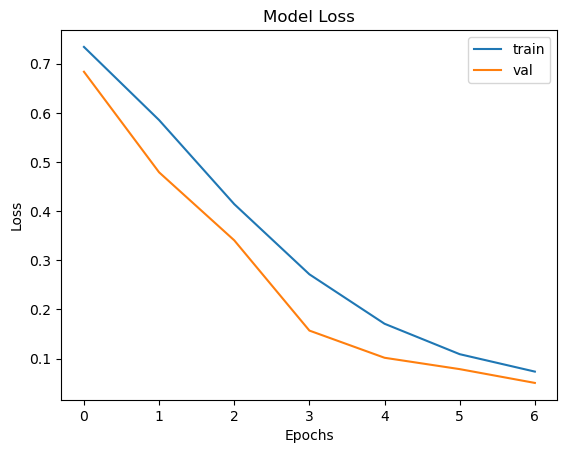

In [34]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["train", "val"])
plt.show()

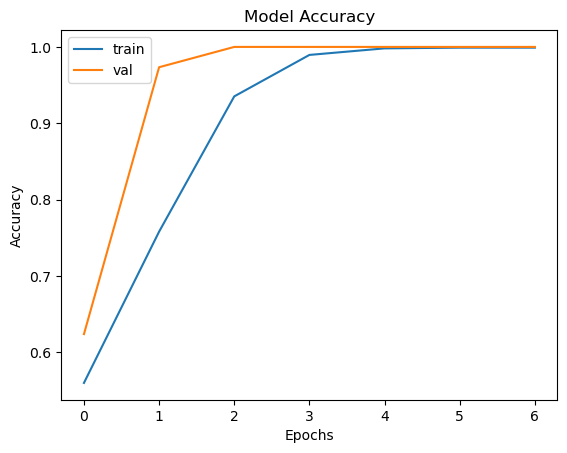

In [33]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])
plt.show()

In [37]:
import pickle

pickle.dump(train_generator, open("train_generator.pkl", "wb"))
model.save("BreastCancerModel.h5")